This tutorial shows the process of creating an apple classifier using deep learning methods. We will use an already created model (VGG-16) and apply transfer learning to the model. In the end, we will implement a model capable of classifying certain apples from our data set.



# Background Information

### What is a CNN?
A convolutional neural network (CNN) is what we refer to as a *model* in deep learning. Convolutional neural networks can learn extremely complex mapping functions when it is trained on enough data. 

CNNs consist of multiple filters, where each filter can be represented as an (n*n) matrix. The training of a CNN consists of finding of the right values on each of the filters so that an input image when passed through the multiple layers, activates certain neurons of the last layer so as to predict the correct class. In our case, we will be trying to predict the correct type of apple.


### What is Transfer Learning?
In transfer learning, we take the pre-trained weights of an already trained model (one that has been trained on millions of images belonging to thousands of classes, on several high power GPU’s for several days!) and use these already learned features to predict new classes. 

The advantages of transfer learning: 
  1. No need for an extremely large dataset.
  2. Not much computational power is required

# Set up environment

We need to install keras (Python Deep Learning Library) and clone a github repo in order to access the Fruits 360 dataset.

In [1]:
!pip install -q keras
!git clone https://github.com/aegarro/FruitClassifierTutorial.git

fatal: destination path 'FruitClassifierTutorial' already exists and is not an empty directory.


In [2]:
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

2.0.0-beta1


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

If your version printed above is **not** 2.0.0, please remove the '#' from the lines below and run the commands to install tensorflow 2.0.0. Next, run the code section above again to validate that '2.0.0-beta1' is printed.


In [3]:
# uncomment the lines below if tensorflow version is NOT 2.0.0
!pip uninstall tensorflow
!pip install tensorflow==2.0.0-beta1

Uninstalling tensorflow-2.0.0b1:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.0.0b1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.0.0b1
  Using cached https://files.pythonhosted.org/packages/29/6c/2c9a5c4d095c63c2fb37d20def0e4f92685f7aee9243d6aae25862694fd1/tensorflow-2.0.0b1-cp36-cp36m-manylinux1_x86_64.whl


Import all needed libraries

In [0]:
import os
import numpy as np
import cv2
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import optimizers

# Train Model

The code section below sets up the path to the images that we are going to use to train our model. There is a training data set and a validation data set. We will use the images in the Training folder to train our model, and use the images in the Test folder to help validate how accurate our model is at classifying the apples.

In [0]:
# directory structure:
# - Training
#     - im1.jpg
#     - im2.jpg
#     - ...
# - Validation
#     - im1.jpg
#     - im2.jpg
#     - ...

THIS_FOLDER = os.path.dirname(os.path.abspath('__file__'))
train_file = os.path.join(THIS_FOLDER, 'FruitClassifierTutorial/fruits-360/Training')
validation_file = os.path.join(THIS_FOLDER, 'FruitClassifierTutorial/fruits-360/Test')
train_dir = train_file
validation_dir = validation_file

Run the code below to print out the classes of apples we will be training our model to identify, and one image from each class will also be printed. (You will also see one banana in the images - this was added for later use)

All classes of apples that we will be classifying:
0. Apple Braeburn
1. Apple Crimson Snow
2. Apple Golden 1
3. Apple Granny Smith
4. Apple Pink Lady
5. Apple Red 1
6. Apple Red Yellow 1
7. Banana



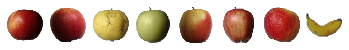

In [6]:
from IPython.display import display
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import PIL.Image
import glob

data_path = os.path.join(train_file,'*')
img_directories = glob.glob(data_path)
classes = []
data_paths = []

# get all unique classes of apples we will be classifying
# for each type of apple, append path to directory (where the images 
# are for each apple)
for dir_path in img_directories:
  classes.append(dir_path.split('/')[-1])
  data_paths.append(dir_path)
classes.sort()
data_paths.sort()

print("All classes of apples that we will be classifying:")
i = 0
for apple in classes:
  print(str(i) + ".", apple)
  i += 1
print()

unique_apples = []

# get 1 image for each type of apple in data set to display
list_of_imgs = []
for apple_path in data_paths:
  imgs_path = os.path.join(apple_path,'*')
  img_1 = glob.glob(imgs_path)[0] # grab first image in folder
  list_of_imgs.append(img_1)

# display the images
def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
      a=fig.add_subplot(1,number_of_files,i+1)
      image = imread(list_of_files[i])
      imshow(image,cmap='Greys_r')
      axis('off')
showImagesHorizontally(list_of_imgs)

Now it is time to set up our pre-trained model VGG16 and train on our Apple images

In [0]:
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(100,100,3))
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(lr=1e-4),metrics=['categorical_accuracy'])


For training a model, image data preparation and augmentation is an important step. Performing data augmentation is a form of regularization, enabling our model to generalize better and Keras provides the ImageDataGenerator class that helps do this for us!

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# flow_from_directory gets the images from the path we gave it
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        validation_dir,
        target_size=(100, 100),
        batch_size=32, shuffle=False)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 100x100
        target_size=(100, 100),
        batch_size=32)

Found 1286 images belonging to 8 classes.
Found 3774 images belonging to 8 classes.



fit_generator() is the function call to train our model. This function uses the image generators created above which will generate the data that is needed to fit the model.

Here the number of epochs is set to 8 which is the number of complete passes through the training dataset. This is a *very* small number, and ideally this number would be set to 100. The same goes for validation_teps which would ideally be set to 50. These are both set to a low number for timing purposes. 

Training should take ~5 min or less, but if you want to increase the accuracy of the model, you need to train for longer. In order to do so, follw these step: 
  1. remove the line 'steps_per_epoch=5,'
  2. set epochs=100
  3. set validation_steps=50


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=5,
      epochs=8,
      validation_data=validation_generator,
      validation_steps=5)


Epoch 1/8
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 51s 10s/step - loss: 2.1758 - categorical_accuracy: 0.1500 - val_loss: 2.0387 - val_categorical_accuracy: 0.0000e+00
Epoch 2/8
5/5 [==============================] - 47s 9s/step - loss: 1.8468 - categorical_accuracy: 0.2911 - val_loss: 2.5140 - val_categorical_accuracy: 0.0000e+00
Epoch 3/8
5/5 [==============================] - 48s 10s/step - loss: 1.2532 - categorical_accuracy: 0.5938 - val_loss: 2.2570 - val_categorical_accuracy: 0.0000e+00
Epoch 4/8
5/5 [==============================] - 47s 9s/step - loss: 0.8782 - categorical_accuracy: 0.7188 - val_loss: 0.6879 - val_categorical_accuracy: 0.5750
Epoch 5/8
4/5 [=======================>......] - ETA: 7s - loss: 0.6104 - categorical_accuracy: 0.7734 

Run the cell below to see the accuracy of your model! 

In [0]:
result = model.evaluate_generator(validation_generator)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

# Predict

Now it is time to see how well our model is at predicting! Remember, we trained our model on 7 classes of apples, and 1 banana. In our dataset, the 7 apples are faily similar and predicting on 8 epochs may not be enough for our model to map out the differences - this is why we have a banana! A banana is very distinct from an apple so our hope is that we can accurately determine this class. 

### How a model predicts
The output of model.predict() is an array of floats where each entry in the array represents the probability of the image belonging to a class.  In our case, we have a total of 8 classes (7 apple, 1 banana). The entries in the array are sorted in alphabetical order.

---
Use these indicies to choose the image to predict.

* 0 - 163 for   Apple Braeburn
* 164 - 311 for Apple Crimson Snow
* 312 - 475 for Apple Golden 1
* 476 - 539 for Apple Granny Smith
* 640 - 791 for Apple Pink Lady
* 792 - 955 for Apple Red 1
* 956 - 1119 for Apple Red Yellow 1
* 1120 - 1285 for Banana
---

In [0]:
# code below used to find start index for each class

# test_images = [validation_generator.filepaths]
# all_apple = test_images[0]
# class_dict = {}
# i = 0
# for path in all_apple:
#   name = path.split("/")[-2]
#   if name not in class_dict:
#     class_dict[name] = i
#   i += 1
# for c in class_dict:
#   print(class_dict[c],c)
# print i

Below is the code to measure the accuracy of classifying a banana

In [0]:
test_images = [validation_generator.filepaths]
all_apple = test_images[0]
i = 1120
wrong = 0
right = 0
while i < 1286:
  first_test_img = all_apple[i] 
  im = cv2.resize(cv2.imread(first_test_img), (100, 100)).astype(np.float32)
  im = np.expand_dims(im, axis=0)
  predictions = model.predict(im)
  pred = np.argmax(predictions)
  if pred != 7:
    wrong +=1
  else:
    right += 1
  i += 1
print(str((right / (right + wrong))*100) + "%")

Classifying the banana did not do too bad compared to the accuracy of other apples! Most of the apple images look alike so most classify as Red Apple, even when they are not labeled as a Red Apple. This makes some of the accuracies around 0%... This problem can be solved by re-training our model above for longer.

Now you can choose your own image and see what your model predicts it is! Sample indices are provided below so that you can choose an image from each class and see what our model will classify it as.

In [0]:
test_images = [validation_generator.filepaths]
all_apple = test_images[0]
first_test_img = all_apple[0]  # change this number to choose image to predict; 
                               # see below for indices

# numbers of index's for test images:
# * 0 - 163   for Apple Braeburn
# * 164 - 311 for Apple Crimson Snow
# * 312 - 475 for Apple Golden 1
# * 476 - 539 for Apple Granny Smith
# * 640 - 791 for Apple Pink Lady
# * 792 - 955 for Apple Red 1
# * 956 -1119 for Apple Red Yellow 1
# * 1120 -1285 for Banana

im = cv2.resize(cv2.imread(first_test_img), (100, 100)).astype(np.float32)
im = np.expand_dims(im, axis=0)
print("predict on this image:")
print(first_test_img)
showImagesHorizontally([first_test_img])


In [0]:
predictions = model.predict(im)
mapping_dictionary = {0: "Apple Braeburn",
                      1: "Apple Crimson Snow",
                      2: "Apple Golden 1",
                      3: "Apple Granny Smith",
                      4: "Apple Pink Lady",
                      5: "Apple Red 1",
                      6: "Apple Red Yellow 1", 
                      7: "Banana"}
pred = np.argmax(predictions)
print("Prediction:", mapping_dictionary[pred])

# Congratulations!

You have built a classifier!